#**Proejct 5**
# **COVID19 Detection from Xray and Explainability**

Haneen Alsuradi 

Net ID: hha243





# **1. Data Preparation**

The first step in approaching this project is to have the sources of your dataset. Here, I uploaded the 3 sources of datasets [MILA, Figure1, RSNA] data to my google drive. Then I will mount my drive to this page for an easy access to the images. Additionally, we upload the configuration file which has all the parameters and paths needed through the code.

**Mount Google Drive content which incldues the dataset from 3 different sources:**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


**Install packages that will be needed in this project.**

In [ ]:
!pip install pydicom
!sudo pip install "pyyaml==5.1"

     |████████████████████████████████| 35.3MB 89kB/s 
     |████████████████████████████████| 276kB 5.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=44135c75c2b5b1a9c9b73e4ffd42d78bf6955ac9dfd222e7adf9651b36be05fb
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Change directory to the project directory where the configuration file and the datasets are:

In [ ]:
%cd gdrive/My\ Drive/Project5/covid-cxr-master

/content/gdrive/My Drive/Project5/covid-cxr-master


First we grab the paths where the datasets are located:

In [ ]:
import numpy as np
import pandas as pd
import pydicom as dicom
import yaml
import os
import pathlib
import shutil
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))  # Load config data

# Get paths of raw datasets to be included
mila_data_path = cfg['PATHS']['MILA_DATA']
fig1_data_path = cfg['PATHS']['FIGURE1_DATA']
rsna_data_path = cfg['PATHS']['RSNA_DATA']

print('Mila data path:', mila_data_path)
print('Figure1 data path:', fig1_data_path)
print('RSNA data path:', rsna_data_path)

Mila data path: /content/gdrive/My Drive/Project5/covid-chestxray-dataset/
Figure1 data path: /content/gdrive/My Drive/Project5/figure1/
RSNA data path: /content/gdrive/My Drive/Project5/rsna/


Then we read the metadata.csv file in each of the datasets folders. metadata.csv has information about the images in the datasets, including labels, notes, patient id, finding, source of the image and most importantly the path to the image. We will first read the csv file in a data frame:

In [ ]:
mila_df = pd.read_csv(mila_data_path + 'metadata.csv')
mila_df.head(5)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


We replace the filename column with the actual compelte path of the image:

---



In [ ]:
mila_df['filename'] = mila_data_path + 'images/' + mila_df['filename'].astype(str)
mila_df.head(5)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 27
0,2,0.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/Project5/covid-chestx...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,infiltrate in the upper lobe of the left lung,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/Project5/covid-chestx...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/Project5/covid-chestx...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/Project5/covid-chestx...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,progressive infiltrate and consolidation,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,/content/gdrive/My Drive/Project5/covid-chestx...,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


Select images that have either PA or AP views. PA and AP are grabbed from the configuration file. '|' is to combine PA and AP to have the logical form PA|AP. The result of this search si a boolean array.

In [ ]:
mila_views_cxrs_df = (mila_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
mila_views_cxrs_df.head(5)

0    True
1    True
2    True
3    True
4    True
Name: view, dtype: bool

Select the images that have COVID-19 cases:

In [ ]:
mila_covid_pts_df = (mila_df['finding'] == 'COVID-19')
mila_covid_pts_df.head(5)

0    True
1    True
2    True
3    True
4    True
Name: finding, dtype: bool

Combine the two conditions (Views of PA|PA and COVID19 cases):

In [ ]:
mila_covid_views_df = mila_df[mila_covid_pts_df & mila_views_cxrs_df]  # Images for patients diagnosed with COVID-19

The same process is done for the other two datasets. 

*   Figure1 dataset doesn't have a "filename" filed in their csv file. We create this field by referring to the patient-id and looking for the patientid in the /images folder (either png or jpg). The dataset, as provided, has PA or AP images even though the "view" column has NA items. Thus, we fill the "views" column with "PA or AP".
*   RSNA metadata csv file doesn't have a filename field too. However, similar to Figure 1 dataset, it has a patient id field from which we can fetch each image's path. Also, the images are available in dcm format. The metadata csv file has a target column which is either 0 "no condition" or 1 "pneumonia". Note that this dataset doens't have any COVID19 cases. However, we use this dataset to populate our training data for the "non COVID-19" class. We split our collection to have 500 images taken from the "no condition" and 500 images from "pneumonia". We create jpg copies in the dataset folder. Note that 500 is half [num_rsna_imgs].

**Note: DCM images have a lot of data embedded and encrypted in them such as Patient name, age, Body part imaged, view, etc. Here we extract the view information using the dicom library**


In [ ]:
# Assemble filenames comprising Figure 1 dataset
fig1_df = pd.read_csv(fig1_data_path + 'metadata.csv', encoding='ISO-8859-1')
fig1_df['filename'] = ''
for i, row in fig1_df.iterrows():
    if os.path.exists(fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'):
        fig1_df.loc[i, 'filename'] = fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'
    else:
        fig1_df.loc[i, 'filename'] = fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.png'
fig1_df['view'].fillna('PA or AP', inplace=True)    # All images in this dataset are either AP or PA
fig1_views_cxrs_df = (fig1_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
fig1_covid_pts_df = (fig1_df['finding'] == 'COVID-19')
fig1_covid_views_df = fig1_df[fig1_covid_pts_df & fig1_views_cxrs_df]  # Images for patients diagnosed COVID-19

# Assemble filenames comprising RSNA dataset
rsna_metadata_path = rsna_data_path + 'stage_2_train_labels.csv'
rsna_df = pd.read_csv(rsna_metadata_path)
num_rsna_imgs = cfg['DATA']['NUM_RSNA_IMGS']
rsna_normal_df = rsna_df[rsna_df['Target'] == 0]
rsna_pneum_df = rsna_df[rsna_df['Target'] == 1]

# Convert dicom files of CXRs with no findings to jpg if not done already in a previous run. Select desired views.
file_counter = 0
normal_idxs = []
for df_idx in rsna_normal_df.index.values.tolist():
    filename = rsna_normal_df.loc[df_idx]['patientId']
    ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
    if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
        if not os.path.exists(rsna_data_path + filename + '.jpg'):
            cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)   # Save as .jpg
        normal_idxs.append(df_idx)
        file_counter += 1
    if file_counter >= num_rsna_imgs // 2:
        break
rsna_normal_df = rsna_normal_df.loc[normal_idxs]


# Convert dicom files of CXRs with pneumonia to jpg if not done already in a previous run. Select desired views.
file_counter = 0
pneum_idxs = []
num_remaining = num_rsna_imgs - num_rsna_imgs // 2
for df_idx in rsna_pneum_df.index.values.tolist():
    filename = rsna_pneum_df.loc[df_idx]['patientId']
    ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
    if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
        if not os.path.exists(rsna_data_path + filename + '.jpg'):
            cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)  # Save as .jpg
        pneum_idxs.append(df_idx)
        file_counter += 1
    if file_counter >= num_remaining:
        break
rsna_pneum_df = rsna_pneum_df.loc[pneum_idxs]

We examine the dataframes for 'no condition' and 'Pneumonia' individuals.

In [ ]:
print('The shape of RSNA No condition dataframe:', rsna_normal_df.shape)
print('The shape of RSNA Pneumonia dataframe:', rsna_pneum_df.shape)
rsna_normal_df.head(3)


The shape of RSNA No condition dataframe: (500, 6)
The shape of RSNA Pneumonia dataframe: (500, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0


Now we fetch more parameters related to the data we want to train out model on. For now, we are considering a binary classification model 'non-COVID-19'or 'COVID-19' as our classes.

In [ ]:
mode = cfg['TRAIN']['CLASS_MODE'] #'non-COVID-19', 'COVID-19'
n_classes = len(cfg['DATA']['CLASSES']) #2
class_dict = {cfg['DATA']['CLASSES'][i]: i for i in range(n_classes)}  # Map class name to number
label_dict = {i: cfg['DATA']['CLASSES'][i] for i in range(n_classes)}  # Map class name to number

print('Mode:', mode)
print('Number of classes:',n_classes)
print('Class dictionary:',class_dict)
print('Label dictionary:',label_dict)

Mode: binary
Number of classes: 2
Class dictionary: {'non-COVID-19': 0, 'COVID-19': 1}
Label dictionary: {0: 'non-COVID-19', 1: 'COVID-19'}


Now we do the following:


*   Add a column for mila_covid df called "label" with values of 1.
*   Create a new dataframe for non-covid cases in mila dataset. Create a label for this df with values =0.
*   Add a column for fig1_covid df called "label" with values of 1.
*   Concatenate RSNA data for normal and Pneumonia cases, add filename column and label them all with 0.
*   Concatenate all the dataframes together.

We have a look at the final dataframe which will proceed with, which basically consists of the filename (path of the image) with its label and string format of the label:







In [ ]:
mila_covid_views_df['label'] = 1                                       # Mila images with COVID-19 diagnosis
mila_other_views_df = mila_df[~mila_covid_pts_df & mila_views_cxrs_df]
mila_other_views_df['label'] = 0                                       # Mila images with alternative diagnoses
fig1_covid_views_df['label'] = 1                                       # Figure 1 images with COVID-19 diagnosis
file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_other_views_df[['filename', 'label']],
                      fig1_covid_views_df[['filename', 'label']]], axis=0)

rsna_df = pd.concat([rsna_normal_df, rsna_pneum_df], axis=0)
rsna_filenames = rsna_data_path + rsna_df['patientId'].astype(str) + '.jpg'
rsna_file_df = pd.DataFrame({'filename': rsna_filenames, 'label': 0})

file_df = pd.concat([file_df, rsna_file_df], axis=0)         # Combine both datasets
file_df['label_str'] = file_df['label'].map(label_dict) # Add column for string representation of label

file_df.head(10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,filename,label,label_str
0,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
1,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
2,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
3,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
4,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
5,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
7,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
8,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
20,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19
21,/content/gdrive/My Drive/Project5/covid-chestx...,1,COVID-19


Now, we split the above data into training, validation and testing while maintaining the ratio of the two classes into each set. Split percentage is fetched from the configuration file. We then save the resulting csv files for the training,validation and testing dataset:

In [ ]:
# Split dataset into train, val and test sets
val_split = cfg['DATA']['VAL_SPLIT']
test_split = cfg['DATA']['TEST_SPLIT']
file_df_train, file_df_test = train_test_split(file_df, test_size=test_split, stratify=file_df['label'])
relative_val_split = val_split / (1 - test_split)  # Calculate fraction of train_df to be used for validation
file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_val_split, stratify=file_df_train['label'])

print('Validation Percentage:', val_split)
print('Test Percentage:', test_split)
print('Relative Validation Percentage:', relative_val_split)

print('Shape of Training data:',file_df_train.shape )
print('Shape of Validation data:',file_df_val.shape )
print('Shape of Testing data:',file_df_test.shape )

# Save training, validation and test sets
file_df_train.to_csv(cfg['PATHS']['TRAIN_SET'])
file_df_val.to_csv(cfg['PATHS']['VAL_SET'])
file_df_test.to_csv(cfg['PATHS']['TEST_SET'])

Validation Percentage: 0.08
Test Percentage: 0.1
Relative Validation Percentage: 0.08888888888888889
Shape of Training data: (1060, 3)
Shape of Validation data: (104, 3)
Shape of Testing data: (130, 3)


# **2. Training**

We import the important libraries that are needed for the training process:

In [ ]:
import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Here we define the path where the log files will be generated during the training process. The logs can be visualized by running TensorBoard. Logs contain data about the experiment, such as metrics throughout the training process on the training and validation sets, and performance on the test set. 

In [ ]:
# Set logs directory
save_weights=True
write_logs=True
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = cfg['PATHS']['LOGS'] + "training" + cur_date if write_logs else None
if not os.path.exists(cfg['PATHS']['LOGS'] + "training"):
    os.makedirs(cfg['PATHS']['LOGS'] + "training")

print('The log files dierctory:',log_dir)

The log files dierctory: /content/gdrive/My Drive/Project5/covid-cxr-master/results/logs/training20200424-062039


We create a dictionary called data and save our training,validation and testing metadata tables in them:

In [ ]:
# Load dataset file paths and labels
data = {} 
data['TRAIN'] = file_df_train
data['VAL'] = file_df_val
data['TEST'] = file_df_test

We create the callbacks which we want to use during the training process. We monitor the validation loss if it stops decreasing (and thus the mode='min'). Patience is the number of epochs that produced the monitored quantity with no improvement after which training will be stopped. The best weights during the last #patience epochs will be restored.

In [ ]:
# Set callbacks.
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=cfg['TRAIN']['PATIENCE'], mode='min', restore_best_weights=True)
callbacks = [early_stopping]
print('Patience: ', cfg['TRAIN']['PATIENCE'])

Patience:  7


Here we append tensorboard to our previosuly created callback list.

In [ ]:
if write_logs:
  tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
  callbacks.append(tensorboard)

Now we define a function, called remove_text to remove some of the artifact texts on some of the xrays. For example, white bright R and L letters are usually printed on the Xray indication the side of the body (left, right). We can test this function as shown below:

In [ ]:
def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result

Test the remove_text function on an XRay that has an artifcat writing on it:

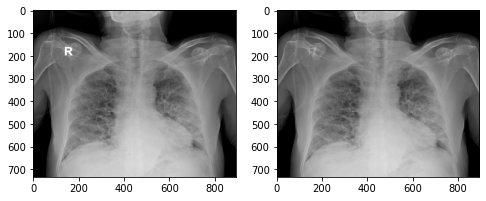

In [ ]:
import glob
import matplotlib.pyplot as plt

cv_img = []
path= glob.glob(data['TRAIN'].values[987][0])
path=path[0]
img = cv2.imread(path)
img_rmv=remove_text(img)

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
fig.add_subplot(rows, columns, 2)
plt.imshow(img_rmv.astype(np.uint8))



Now we create the image generators for the training, validation, and testing sets:

In [ ]:
# Create ImageDataGenerators
train_img_gen = ImageDataGenerator(rotation_range=10, preprocessing_function=remove_text,
                                    samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                    samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                    samplewise_std_normalization=True, samplewise_center=True)


Using the image generators that we created, now we create dataframe iterators for the training, validation, and testing sets:

In [ ]:
# Create DataFrameIterators
img_shape = tuple(cfg['DATA']['IMG_DIM'])
y_col = 'label_str'
class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(dataframe=data['TRAIN'], directory=None,
    x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode)
val_generator = val_img_gen.flow_from_dataframe(dataframe=data['VAL'], directory=None,
    x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode)
test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'], directory=None,
    x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode,
    shuffle=False)

Found 1060 validated image filenames belonging to 2 classes.
Found 104 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.


Saving the model class_indicies in .pkl format. This will be used later on. We print class_indicies for demonstration.

In [ ]:
# Save model's ordering of class indices
dill.dump(test_generator.class_indices, open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'wb'))
print(test_generator.class_indices)

{'COVID-19': 0, 'non-COVID-19': 1}


As mentioned before, the data we have is skewed since we have many more non COVID-19 cases vs COVID-19 cases. Thus, we create a class_weight vector the penalizes COVID-19 misclassification much more. We further tweak the class weight using the class multiplier which gives further control on the penalty (in addition to the calculated weights).

In [ ]:
# Apply class imbalance strategy. We have many more X-rays negative for COVID-19 than positive.

# Get class mutliplier [the tweaking part]
class_multiplier = cfg['TRAIN']['CLASS_MULTIPLIER']
class_multiplier = [class_multiplier[cfg['DATA']['CLASSES'].index(c)] for c in test_generator.class_indices]
print('Class Multiplier:', class_multiplier)

#get the actual class weights
class_weight = None
histogram = np.bincount(np.array(train_generator.labels).astype(int))  # Get class distribution
print('COVID-19 cases vs Non COVID-19 in the training set:', histogram)


weights = [None] * len(histogram)
for i in range(len(histogram)):
    weights[i] = (1.0 / len(histogram)) * sum(histogram) / histogram[i]
class_weight_d = {i: weights[i] for i in range(len(histogram))}
print('Class weights before class multiplier: ', weights)
class_weight = [class_weight_d[i] * class_multiplier[i] for i in range(len(histogram))]
print('Class weights after class multiplier: ', class_weight)

Class Multiplier: [1.0, 0.15]
COVID-19 cases vs Non COVID-19 in the training set: [185 875]
Class weights before class multiplier:  [2.864864864864865, 0.6057142857142858]
Class weights after class multiplier:  [2.864864864864865, 0.09085714285714286]


F1 Score metric is defined to be used as part of the needed metrics

In [ ]:
import numpy as np
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.python.keras import backend as K

class F1Score(Metric):
    '''
    Custom tf.keras metric that calculates the F1 Score
    '''

    def __init__(self, thresholds=None, top_k=None, class_id=None, name=None, dtype=None):
        '''
        Creates an instance of the  F1Score class
        :param thresholds: A float value or a python list/tuple of float threshold values in [0, 1].
        :param top_k: An int value specifying the top-k predictions to consider when calculating precision
        :param class_id: Integer class ID for which we want binary metrics. This must be in the half-open interval
                `[0, num_classes)`, where `num_classes` is the last dimension of predictions
        :param name: string name of the metric instance
        :param dtype: data type of the metric result
        '''
        super(F1Score, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self.true_positives = self.add_weight('true_positives', shape=(len(self.thresholds),),
                                              initializer=init_ops.zeros_initializer)
        self.false_positives = self.add_weight('false_positives', shape=(len(self.thresholds),),
                                               initializer=init_ops.zeros_initializer)
        self.false_negatives = self.add_weight('false_negatives', shape=(len(self.thresholds),),
                                               initializer=init_ops.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates true positive, false positive and false negative statistics.
        :param y_true: The ground truth values, with the same dimensions as `y_pred`. Will be cast to `bool`
        :param y_pred: The predicted values. Each element must be in the range `[0, 1]`
        :param sample_weight: Weighting of each example. Defaults to 1. Can be a `Tensor` whose rank is either 0,
               or the same rank as `y_true`, and must be broadcastable to `y_true`
        :return: Update operation
        '''
        metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
            },
            y_true, y_pred, thresholds=self.thresholds, top_k=self.top_k, class_id=self.class_id,
            sample_weight=sample_weight)


    def result(self):
        '''
        Compute the value for the F1 score. Calculates precision and recall, then F1 score.
        F1 = 2 * precision * recall / (precision + recall)
        :return: F1 score
        '''
        precision = math_ops.div_no_nan(self.true_positives, self.true_positives + self.false_positives)
        recall = math_ops.div_no_nan(self.true_positives, self.true_positives + self.false_negatives)
        result = math_ops.div_no_nan(2 * precision * recall, precision + recall)
        return result[0] if len(self.thresholds) == 1 else result

    def reset_states(self):
        '''
        Resets all of the metric state variables. Called between epochs, when a metric is evaluated during training.
        '''
        num_thresholds = len(to_list(self.thresholds))
        K.batch_set_value(
            [(v, np.zeros((num_thresholds,))) for v in self.variables])

    def get_config(self):
        '''
        Returns the serializable config of the metric.
        :return: serializable config of the metric
        '''
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(F1Score, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Define all the metrics that will be used to evaluate the model. Since the data is skewed, accuracy is not an enough metric. Other metrics such as Precision, Recall, AUC and F1Score are needed. Since this classification is binary, the threshold is 0.5.

In [ ]:
# Define metrics.
covid_class_idx = test_generator.class_indices['COVID-19']   # Get index of COVID-19 class
thresholds = 1.0 / len(cfg['DATA']['CLASSES'])      # Binary classification threshold for a class
metrics = [CategoricalAccuracy(name='accuracy'),
            Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
            Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
            AUC(name='auc'),
            F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

Since we will choose RESNET50v2 as the model to be used, we define this model under this function to be handy to use. We use a pretrained version of ResNet50V2 and import its weights. Those weights were obtained after training the ResNet50v2 on "imagenet" dataset. So in short we are using "Transfer Learning". We add few layers at the end that will be trained to tailor the network to COVID-19 X-ray classification.

In [ ]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPool2D, Conv2D, Flatten, LeakyReLU, BatchNormalization, \
    Activation, concatenate, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import Constant
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2
from tensorflow.keras.utils import multi_gpu_model
def resnet50v2(model_config, input_shape, metrics, n_classes=2, output_bias=None, gpus=1):
    '''
    Defines a model based on a pretrained ResNet50V2 for multiclass X-ray classification.
    :param model_config: A dictionary of parameters associated with the model architecture
    :param input_shape: The shape of the model input
    :param metrics: Metrics to track model's performance
    :return: a Keras Model object with the architecture defined in this method
    '''

    # Set hyperparameters
    nodes_dense0 = model_config['NODES_DENSE0']
    lr = model_config['LR']
    dropout = model_config['DROPOUT']
    l2_lambda = model_config['L2_LAMBDA']
    if model_config['OPTIMIZER'] == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif model_config['OPTIMIZER'] == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = Adam(learning_rate=lr)  # For now, Adam is default option

    # Set output bias
    if output_bias is not None:
        output_bias = Constant(output_bias)
    print("MODEL CONFIG: ", model_config)

    # Start with pretrained ResNet50V2
    pretrained_resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    X = pretrained_resnet.output

    # Add custom top
    X = GlobalAveragePooling2D()(X)
    X = Dropout(dropout)(X)
    X = Dense(nodes_dense0, kernel_initializer='he_uniform', activity_regularizer=l2(l2_lambda))(X)
    X = LeakyReLU()(X)
    X = Dense(n_classes, bias_initializer=output_bias)(X)
    Y = Activation('softmax', dtype='float32', name='output')(X)

    # Set model loss function, optimizer, metrics.
    model = Model(inputs=pretrained_resnet.input, outputs=Y)
    if gpus >= 2:
        model = multi_gpu_model(model, gpus=gpus)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
    model.summary()
    return model

Here, the model parameters are defined. cfg['NN']['DCNN_BINARY'] defines all the neural network related parameters including the stride,filters, kernels, learning rate, optimizer, dropout, etc. The model summary is printed with all its relevant parameters

In [ ]:
# Define the model.
print('Training distribution: ', ['Class ' + list(test_generator.class_indices.keys())[i] + ': ' + str(histogram[i]) + '. '
        for i in range(len(histogram))])  #printing histogram values for each class
input_shape = cfg['DATA']['IMG_DIM'] + [3] #adding the third dimention for channel (RGB)
print('Input Shape:', input_shape)
num_gpus = cfg['TRAIN']['NUM_GPUS']
print('Number of GPUs: ', num_gpus)
model_def = resnet50v2

histogram = np.bincount(data['TRAIN']['label'].astype(int))
print('Histogram info: ', histogram)
output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
print('Output Bias: ', output_bias)
model = model_def(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=num_gpus)


Training distribution:  ['Class COVID-19: 185. ', 'Class non-COVID-19: 875. ']
Input Shape: [224, 224, 3]
Number of GPUs:  1
Histogram info:  [875 185]
Output Bias:  [ 1.55386806 -1.55386806]
MODEL CONFIG:  {'KERNEL_SIZE': '(3,3)', 'STRIDES': '(1,1)', 'INIT_FILTERS': 16, 'FILTER_EXP_BASE': 3, 'MAXPOOL_SIZE': '(2,2)', 'CONV_BLOCKS': 3, 'NODES_DENSE0': 128, 'LR': 0.0003, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
94674944/94668760 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                

In [ ]:
# Train the model.
steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
print('Steps Per Epoch: ',steps_per_epoch)
val_steps = ceil(val_generator.n / val_generator.batch_size)
print('Validation Steps: ',val_steps)
epochs=epochs=cfg['TRAIN']['EPOCHS']
print('Epochs: ', epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                              verbose=1, class_weight=class_weight_d)

Steps Per Epoch:  34
Validation Steps:  4
Epochs:  200
Epoch 1/200
34/34 [==============================] - 65s 2s/step - loss: 0.0527 - accuracy: 0.9811 - precision: 0.9064 - recall: 0.9946 - auc: 0.9974 - f1score: 0.9485 - val_loss: 0.3298 - val_accuracy: 0.8173 - val_precision: 0.5625 - val_recall: 0.7826 - val_auc: 0.9361 - val_f1score: 0.6545
Epoch 2/200
34/34 [==============================] - 65s 2s/step - loss: 0.0492 - accuracy: 0.9830 - precision: 0.9167 - recall: 0.9888 - auc: 0.9979 - f1score: 0.9514 - val_loss: 0.3984 - val_accuracy: 0.8654 - val_precision: 0.6000 - val_recall: 0.6667 - val_auc: 0.9638 - val_f1score: 0.6316
Epoch 3/200
34/34 [==============================] - 64s 2s/step - loss: 0.0499 - accuracy: 0.9821 - precision: 0.9198 - recall: 0.9898 - auc: 0.9976 - f1score: 0.9535 - val_loss: 0.2584 - val_accuracy: 0.9135 - val_precision: 0.7368 - val_recall: 0.7778 - val_auc: 0.9656 - val_f1score: 0.7568
Epoch 4/200
34/34 [==============================] - 64s 2s/

Save the trained MODEL in a .h5 format:

In [ ]:
if save_weights:
  model_path = cfg['PATHS']['MODEL_WEIGHTS'] + 'model' + '.h5'
  save_model(model, model_path)  # Save the model's weights

# **3. Model Evaluation**

Run the trained model on the testing data set. Summary of the performance metrics:

In [ ]:
# Run the model on the test set and print the resulting performance metrics.
test_results = model.evaluate(test_generator, verbose=1, steps=len(test_generator))
test_metrics = {}
test_summary_str = [['**Metric**', '**Value**']]
for metric, value in zip(model.metrics_names, test_results):
    test_metrics[metric] = value
    print(metric, ' = ', value)
    test_summary_str.append([metric, str(value)])

5/5 [==============================] - 5s 998ms/step - loss: 0.4028 - accuracy: 0.8769 - precision: 0.6296 - recall: 0.7391 - auc: 0.9362 - f1score: 0.6800
loss  =  0.402803510427475
accuracy  =  0.8769230842590332
precision  =  0.6296296119689941
recall  =  0.739130437374115
auc  =  0.936212956905365
f1score  =  0.6799999475479126


We plot the receiver operating characteristic curve, or ROC curve, to illustrates the diagnostic ability of a binary classifier

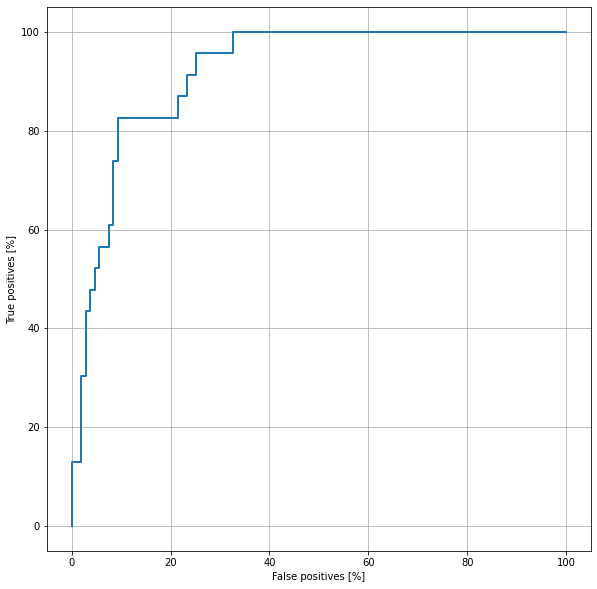

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import io
import os
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries

# Set some matplotlib parameters
mpl.rcParams['figure.figsize'] = (12, 10)

def plot_to_tensor():
    '''
    Converts a matplotlib figure to an image tensor
    :param figure: A matplotlib figure
    :return: Tensorflow tensor representing the matplotlib image
    '''
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    image_tensor = tf.image.decode_png(buf.getvalue(), channels=4)     # Convert .png buffer to tensorflow image
    image_tensor = tf.expand_dims(image_tensor, 0)     # Add the batch dimension
    return image_tensor

def plot_roc(name, labels, predictions, class_id=1, dir_path=None):
    '''
    Plots the ROC curve for predictions on a dataset
    :param name: Name of dataset on the plot
    :param labels: Ground truth labels
    :param predictions: Model predictions corresponding to the labels
    :param class_id: Index of class to consider
    :param dir_path: Directory in which to save image
    '''
    plt.clf()
    single_class_preds = predictions[:, class_id]    # Only care about one class
    single_class_labels = (np.array(labels) == class_id) * 1.0
    predictions = single_class_preds
    labels = single_class_labels
    fp, tp, _ = roc_curve(labels, predictions)  # Get values for true positive and true negative
    plt.plot(100*fp, 100*tp, label=name, linewidth=2)   # Plot the ROC curve
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-5,105])
    plt.ylim([-5,105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        plt.savefig(dir_path + 'ROC_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')
    return plt


# Visualization of test results
test_predictions = model.predict_generator(test_generator, verbose=0, steps=len(test_generator))
test_labels = test_generator.labels
covid_idx = test_generator.class_indices['COVID-19']
plt = plot_roc("Test set", test_labels, test_predictions, class_id=covid_idx)
roc_img = plot_to_tensor()


True (-)ves:  97 
False (+)ves:  10 
False (-)ves:  6 
True (+)ves:  17


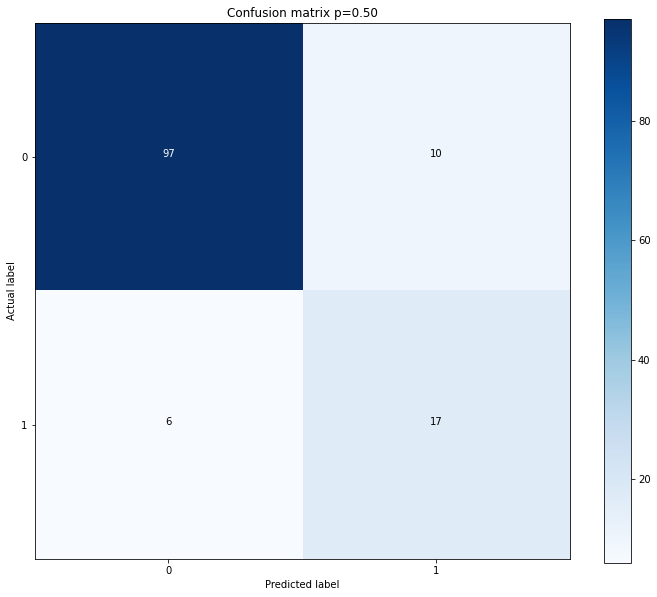

In [ ]:
def plot_confusion_matrix(labels, predictions, class_id=1, dir_path=None):
    '''
    Plot a confusion matrix for the ground truth labels and corresponding model predictions for a particular class.
    :param labels: Ground truth labels
    :param predictions: Model predictions
    :param class_id: Index of class to consider
    :param dir_path: Directory in which to save image
    '''
    plt.clf()
    p = 1.0 / np.unique(labels).shape[0]
    single_class_preds = predictions[:, class_id]    # Only care about one class
    single_class_labels = (np.array(labels) == class_id) * 1.0
    predictions = single_class_preds
    labels = single_class_labels
    ax = plt.subplot()
    cm = confusion_matrix(labels, predictions > p)  # Calculate confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Plot confusion matrix
    ax.figure.colorbar(im, ax=ax)
    ax.set(yticks=[-0.5, 1.5], xticks=[0, 1], yticklabels=['0', '1'], xticklabels=['0', '1'])
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(base=1, offset=0.5))

    # Print number of TPs, FPs, TNs, FNs on each quadrant in the plot
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Set plot's title and axis names
    plt.title('Confusion matrix p={:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # Save the image
    if dir_path is not None:
        plt.savefig(dir_path + 'CM_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')

    # Print these statistics
    print('True (-)ves: ', cm[0][0], '\nFalse (+)ves: ', cm[0][1], '\nFalse (-)ves: ', cm[1][0], '\nTrue (+)ves: ',
          cm[1][1])
    return plt
plt = plot_confusion_matrix(test_labels, test_predictions, class_id=covid_idx)
cm_img = plot_to_tensor()

Metrics of training and validation are plotted vs epochs:

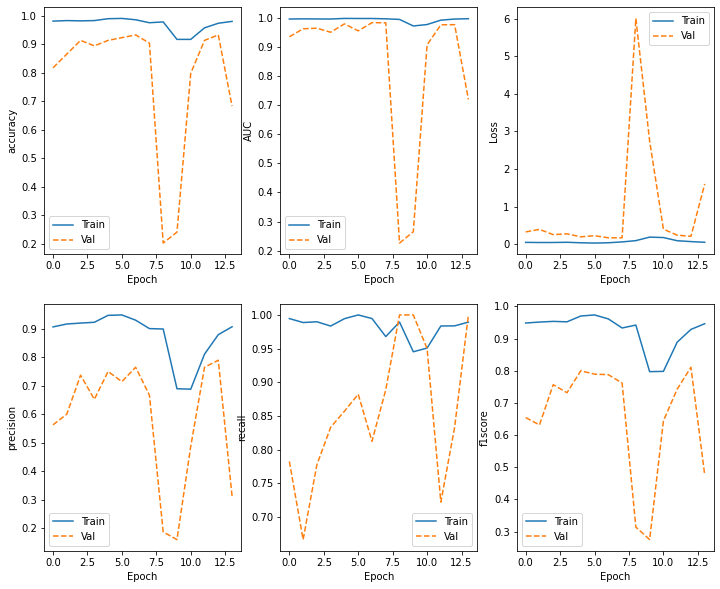

In [ ]:
def plot_metrics(history, metrics, dir_path=None):
    '''
    Plot metrics for the training and validation sets over the training history.
    :param history: Model history; returned from model.fit()
    :param metrics: List of metrics to plot
    :param dir_path: Directory in which to save image
    '''
plt.clf()
plt.subplot(2,3,1)
plt.plot(history.epoch,  history.history['accuracy'], label='Train')    # Plot metric on training data
plt.plot(history.epoch, history.history['val_'+'accuracy'], linestyle="--", label='Val')    # Plot metric on validation data
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2,3,2)
plt.plot(history.epoch,  history.history['auc'], label='Train')    # Plot metric on training data
plt.plot(history.epoch, history.history['val_'+'auc'], linestyle="--", label='Val')    # Plot metric on validation data
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.subplot(2,3,3)
plt.plot(history.epoch,  history.history['loss'], label='Train')    # Plot metric on training data
plt.plot(history.epoch, history.history['val_'+'loss'], linestyle="--", label='Val')    # Plot metric on validation data
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,3,4)
plt.plot(history.epoch,  history.history['precision'], label='Train')    # Plot metric on training data
plt.plot(history.epoch, history.history['val_'+'precision'], linestyle="--", label='Val')    # Plot metric on validation data
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()

plt.subplot(2,3,5)
plt.plot(history.epoch,  history.history['recall'], label='Train')    # Plot metric on training data
plt.plot(history.epoch, history.history['val_'+'recall'], linestyle="--", label='Val')    # Plot metric on validation data
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()


plt.subplot(2,3,6)
plt.plot(history.epoch,  history.history['f1score'], label='Train')    # Plot metric on training data
plt.plot(history.epoch, history.history['val_'+'f1score'], linestyle="--", label='Val')    # Plot metric on validation data
plt.xlabel('Epoch')
plt.ylabel('f1score')
plt.legend()


# **4. Explainability**

## **Lime Explainer:**

In [ ]:
!pip install lime

In [ ]:
from lime.lime_image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from datetime import datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries

def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):
    '''
    Visualize an explanation for the prediction of a single X-ray image.
    :param orig_img: Original X-Ray image
    :param explanation: ImageExplanation object
    :param img_filename: Filename of the image explained
    :param label: Ground truth class of the example
    :param probs: Prediction probabilities
    :param class_names: Ordered list of class names
    :param label_to_see: Label to visualize in explanation
    :param dir_path: Path to directory where to save the generated image
    :return: Path to saved image
    '''

    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10,
                                                hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.02, 0.8, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.82, "Predicted Class: " + str(pred_class) + ' (' + class_names[pred_class] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.84, "Ground Truth Class: " + str(label) + ' (' + class_names[label] + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=15)
    fig.tight_layout()

    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = dir_path + img_filename + '_exp_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png'
        plt.savefig(filename)
    return filename



Found 130 validated image filenames belonging to 2 classes.
130/130 [==============================] - 6s 49ms/step



Intercept 1.6808046290170793
Prediction_local [-0.77235834]
Right: 0.00025741602
Intercept -0.6808046317504142
Prediction_local [1.77235834]
Right: 0.99974257


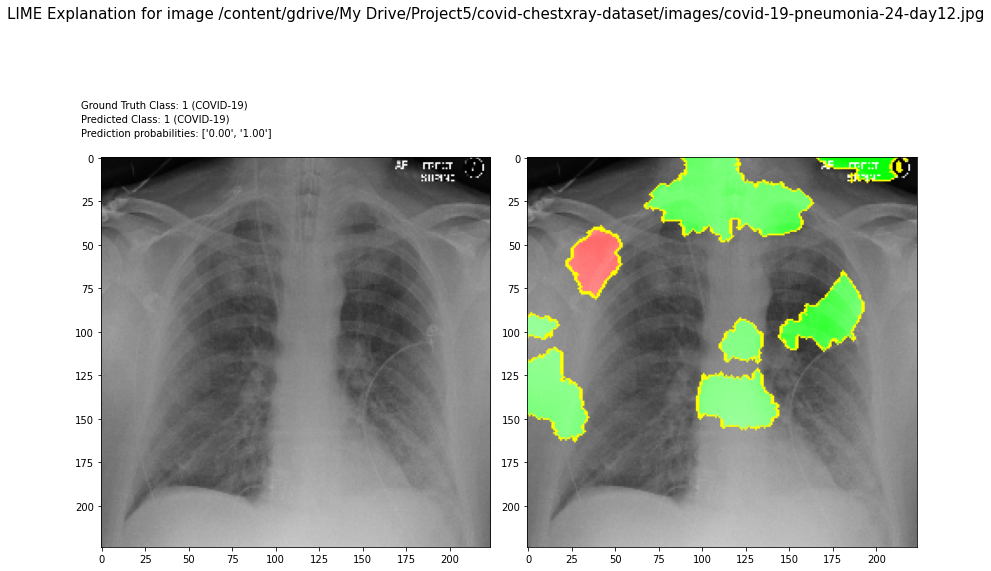

In [ ]:
from lime.lime_image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from datetime import datetime
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries
def predict_and_explain(x, model, exp, num_features, num_samples):
    '''
    Use the model to predict a single example and apply LIME to generate an explanation.
    :param x: Preprocessed image to predict
    :param model: The trained neural network model
    :param exp: A LimeImageExplainer object
    :param num_features: # of features to use in explanation
    :param num_samples: # of times to perturb the example to be explained
    :return: The LIME explainer for the instance
    '''

    def predict(x):
        '''
        Helper function for LIME explainer. Runs model prediction on perturbations of the example.
        :param x: List of perturbed examples from an example
        :return: A numpy array constituting a list of class probabilities for each predicted perturbation
        '''
        probs = predict_instance(x, model)
        return probs

    # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)

    # Generate explanation for the example
    explanation = exp.explain_instance(x, predict, num_features=num_features, num_samples=num_samples, segmentation_fn=segmentation_fn)
    probs = predict_instance(np.expand_dims(x, axis=0), model)
    return explanation, probs


def predict_instance(x, model):
    '''
    Runs model prediction on 1 or more input images.
    :param x: Image(s) to predict
    :param model: A Keras model
    :return: A numpy array comprising a list of class probabilities for each prediction
    '''
    y = model.predict(x)  # Run prediction on the perturbations
    if y.shape[1] == 1:
        probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
    else:
        probs = y
    return probs

def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    lime_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=None,
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', shuffle=False)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    dill.dump(lime_dict['EXPLAINER'], open(cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    #lime_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
    lime_dict['MODEL']=model
    test_predictions = lime_dict['MODEL'].predict_generator(test_generator, verbose=1,steps=len(test_generator))
    return lime_dict


def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread( lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    explanation, probs = predict_and_explain(x, lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                      lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see
                          )
    return


lime_dict = setup_lime()
i = 3                                                    # Select i'th image in test set
explain_xray(lime_dict, i, save_exp=True)                   # Generate explanation for image

## **Shapely Exaplainer:**

In [ ]:
!pip install shap

     |████████████████████████████████| 276kB 6.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394138 sha256=aa448dfbe5229d45168dba8255c0b000fc178424b28e92d5ba052f67c18075cf
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap
import glob
import matplotlib.pyplot as plt


samples=len(data['TRAIN'])
X=np.full((samples,224,224,3), 0)
y=np.full((samples), 0)
new_dim=tuple(lime_dict['IMG_DIM'])
for i in range(samples):
  cv_img = []
  path= glob.glob(data['TRAIN'].values[i][0])
  path=path[0]
  img = cv2.imread(path)
  orig_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image
  X[i]=orig_img
  y[i]= data['TRAIN'].values[i][1]# Get the corresponding original image (no preprocessing)

to_explain = X[[1]]
model=load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)


e = shap.GradientExplainer(model, X, session=None, local_smoothing=0)
# get the names for the classes
#index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)




Using TensorFlow backend.


In [ ]:
shap_values,indexes = e.shap_values(map2layer(to_explain, 2), ranked_outputs=2)


TypeError: ignored

# **5. Explaining SHAP issue with Tensorflow**

It can be seen that there is an integration problem between shap algorithm and tensorflow. I have tried to downgrade TF and Keras versions but this didn't resolve the compatibility issue as I belive the ResNet Model is built with the newer versions of TF. Thus, it is not possible to solve this integration problem at the moment as SHAP needs an older version of TF while at the same time our model needs the newer version.


There are two SHAP algorithms which can be used for exaplaining deep learning models: 

1. The first is DeepExplainer 

2. The second is GradientExplainer. 

I tried both of them and both are not working too due to the same compatability issue.

To confirm this issue, I ran the example on the README in the github of SHAP that are related to explaining CNN models. The first example used DeepExplainer with MNIST dataset and the second example used GradientExplainer with VGG16 network. Both of the reday examples didn't run and gave the same error that can be seen above.


# **6. Two page report on Shapley:**

Below you can find a hyperlink for a google doc I wrote on Shapley algorithm. This is the second task in Project 5.
https://drive.google.com/file/d/1g6f4aeN9T8FSRSMmUqC38m5lOYcHavXE/view?usp=sharing
